<a href="https://colab.research.google.com/github/Leonardo-Dias-Up/Leonardo-Dias-Up/blob/main/Economia_Brasileira_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Política Cambial Brasileira e o Acirramento político 1999-2018.

In [1]:
!pip install python-bcb
!pip install ipeadatapy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 115.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 KB 13.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [113]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import find_peaks
from bcb import sgs
from bcb import currency
from bcb import PTAX
from bcb import Expectativas
from bcb import TaxaJuros
import ipeadatapy as idpy
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.api import VAR
from google.colab import auth
from google.cloud import bigquery
from google.oauth2 import service_account
mpl.style.use('bmh')

  
> Para analisar o efeito de cada governo do período mencionado sobre o câmbio brasileiro, podemos começar coletando e tratando os dados de duas séries temporais principais: a taxa de câmbio nominal (PTAX) e a taxa de câmbio real (IPCA).

> A taxa de câmbio nominal (PTAX) é a taxa de câmbio oficial divulgada pelo Banco Central do Brasil, que indica a taxa de conversão entre o real brasileiro e outras moedas estrangeiras. A taxa de câmbio real (IPCA) leva em consideração a inflação no Brasil e nos países estrangeiros para calcular o valor real do câmbio.

> Para coletar os dados dessas séries temporais, podemos utilizar o pacote python-bcb que você mencionou anteriormente. O código para coletar os dados pode ser semelhante ao seguinte:
  



In [3]:
# Coleta os dados da PTAX e tratar para observações mensais
ptax = sgs.get(10813, start='1995-01-01', end='2018-12-31')
ptax = ptax.rename(columns={'10813':'ptax'})
ptax = ptax.resample('M').last()
ptax = ptax[1:]

# Coleta os dados do IPCA
ipca = sgs.get(13522, start='1995-01-01', end='2018-12-31')
ipca = ipca.rename(columns={'13522':'ipca'})

# Coleta os dados da Meta Selic
selic_meta = sgs.get('432', '1999-01-01', '2018-12-31')
selic_meta = selic_meta.resample('M').mean()
selic_meta = selic_meta.rename(columns={'432': 'selic_meta'})

# Coleta os dados do IBC-Br - índice real (2002=100)
ibc = sgs.get('24364', '2003-01-01', '2018-12-31') # sazonalizada 24363
ibc = ibc.rename(columns={'24364': 'ibc'})

# Coleta os dados da taxa de desemprego utilizando a função timeseries da biblioteca ipeadatapy
desemprego = idpy.timeseries("SEADE12_TDTGSP12")
desemprego = desemprego[(desemprego.index.year >= 1999) & (desemprego.index.year <= 2018)][['VALUE ((%))']].rename(columns= {'VALUE ((%))':'desemprego'})
desemprego = desemprego.rename_axis('Date')

In [99]:
# Configurar o cliente do BigQuery
credentials = service_account.Credentials.from_service_account_file(r"/content/drive/MyDrive/Colab Notebooks/TCC/bigquey-chave.json")
project_id = 'rais-359504'
client = bigquery.Client(credentials=credentials, project=project_id)

# Definir a query
total_filiados = """ SELECT ano, mes, SUM(total_filiados) AS total_filiados FROM (SELECT EXTRACT(YEAR FROM data_filiacao) AS ano, EXTRACT(MONTH FROM data_filiacao) AS mes, COUNT(*) AS total_filiados, sigla_partido FROM `basedosdados.br_tse_filiacao_partidaria.microdados` WHERE sigla_partido IN ('PT', 'MDB') AND EXTRACT(YEAR FROM data_filiacao) BETWEEN 1999 AND 2018 GROUP BY ano, mes, sigla_partido) GROUP BY ano, mes ORDER BY ano, mes """

total_filiados_por_partido = """SELECT EXTRACT(YEAR FROM data_filiacao) AS ano, EXTRACT(MONTH FROM data_filiacao) AS mes, COUNT(*) AS total_filiados, sigla_partido FROM `basedosdados.br_tse_filiacao_partidaria.microdados` WHERE sigla_partido IN ('PT', 'MDB') AND EXTRACT(YEAR FROM data_filiacao) BETWEEN 1999 AND 2018 GROUP BY ano, mes, sigla_partido ORDER BY ano, mes, sigla_partido"""

# Executar a query
query_job_1 = client.query(total_filiados)
total_filiados = query_job_1.to_dataframe()
total_filiados.index = pd.date_range(start='01/01/1999', periods=len(total_filiados), freq='M')

# Executar a query
query_job_2 = client.query(total_filiados_por_partido)
total_filiados_por_partido = query_job_2.to_dataframe()
total_filiados_por_partido['Date'] = pd.to_datetime(total_filiados_por_partido['ano'].astype(str) + '/' + total_filiados_por_partido['mes'].astype(str) + '/01')
total_filiados_por_partido = total_filiados_por_partido.pivot(index='Date', columns='sigla_partido', values='total_filiados')

# Concatenação dos dataframes
total_filiados_por_partido = pd.concat([total_filiados_por_partido, total_filiados], axis=1)

# Agrupamento por mês
total_filiados_por_partido = total_filiados_por_partido.groupby(total_filiados_por_partido.index.strftime('%Y-%m')).mean()
total_filiados_por_partido = total_filiados_por_partido.drop(columns=['ano','mes'])

In [100]:
# Ordenando os dados por data
df = total_filiados_por_partido

# Calculando o índice de Gini
# Calculando a participação acumulada de filiados de cada partido
df['partic_acum_MDB'] = df['MDB'].cumsum()
df['partic_acum_PT'] = df['PT'].cumsum()

# Calculando a participação relativa dos filiados de cada partido ao total de filiados
df['partic_rel_MDB'] = df['MDB'] / df['total_filiados']
df['partic_rel_PT'] = df['PT'] / df['total_filiados']
df['partic_rel_sqr_MDB'] = df['partic_rel_MDB'] ** 2
df['partic_rel_sqr_PT'] = df['partic_rel_PT'] ** 2

# Calculando o índice de Gini para cada observação
partic_acum_MDB = df['partic_acum_MDB']
partic_acum_PT = df['partic_acum_PT']
S = partic_acum_MDB.iloc[-1] + partic_acum_PT.iloc[-1]
df['gini'] = 1 - (2*(df['partic_rel_MDB']*partic_acum_PT + df['partic_rel_sqr_MDB']*partic_acum_PT + df['partic_rel_PT']*partic_acum_MDB + df['partic_rel_sqr_PT']*partic_acum_MDB).cumsum() + (partic_acum_PT - partic_acum_MDB)*S) / S**2

## Transforma as datas em objetos do tipo datetime
df.index = pd.to_datetime(df.index)
total_filiados_por_partido = df
total_filiados_por_partido.head()

,MDB,PT,total_filiados,partic_acum_MDB,partic_acum_PT,partic_rel_MDB,partic_rel_PT,partic_rel_sqr_MDB,partic_rel_sqr_PT,gini
1999-01-01,3257.0,5087.0,8344.0,3257.0,5087.0,0.39034,0.60966,0.152366,0.371685,0.999402
1999-02-01,4001.0,1849.0,5850.0,7258.0,6936.0,0.683932,0.316068,0.467762,0.099899,1.000105
1999-03-01,23808.0,4812.0,28620.0,31066.0,11748.0,0.831866,0.168134,0.692001,0.028269,1.006316
1999-04-01,19273.0,9981.0,29254.0,50339.0,21729.0,0.658816,0.341184,0.434038,0.116407,1.009354
1999-05-01,4494.0,6012.0,10506.0,54833.0,27741.0,0.427756,0.572244,0.182975,0.327464,1.008858


In [101]:
# Transforma as datas em objetos do tipo datetime
ptax.index = pd.to_datetime(ptax.index)
ipca.index = pd.to_datetime(ipca.index)
selic_meta.index = pd.to_datetime(selic_meta.index)
ibc.index = pd.to_datetime(ibc.index)
desemprego.index = pd.to_datetime(desemprego.index)

# Extrai apenas o ano e o mês das datas
ptax_monthly_index = ptax.index.strftime('%Y-%m')
ipca_monthly_index = ipca.index.strftime('%Y-%m')
selic_meta_monthly_index = selic_meta.index.strftime('%Y-%m')
ibc_monthly_index = ibc.index.strftime('%Y-%m')
desemprego_monthly_index = desemprego.index.strftime('%Y-%m')

print([total_filiados_por_partido])
# Concatenação dos dataframes
df = pd.concat([ptax, ipca, selic_meta, ibc,total_filiados_por_partido, desemprego], axis=1)

# Agrupamento por mês
dados_economicos = df.groupby(df.index.strftime('%Y-%m')).mean()
dados_economicos = dados_economicos.dropna()

# Cria variáveis dummy para cada período governamental
dados_economicos['fhc'] = np.where((dados_economicos.index >= '1999-01') & (dados_economicos.index <= '2002-12'), 1, 0)
dados_economicos['lula'] = np.where((dados_economicos.index >= '2003-01') & (dados_economicos.index <= '2010-12'), 1, 0)
dados_economicos['dilma'] = np.where((dados_economicos.index >= '2011-01') & (dados_economicos.index <= '2014-12'), 1, 0)
dados_economicos['temer'] = np.where((dados_economicos.index >= '2018-12'), 1, 0)
print(dados_economicos.columns)
dados_economicos = dados_economicos[['ptax', 'ipca', 'selic_meta', 'ibc', 'desemprego', 'fhc', 'lula', 'dilma', 'temer']]


[                MDB      PT  total_filiados partic_acum_MDB partic_acum_PT  \
1999-01-01   3257.0  5087.0          8344.0          3257.0         5087.0   
1999-02-01   4001.0  1849.0          5850.0          7258.0         6936.0   
1999-03-01  23808.0  4812.0         28620.0         31066.0        11748.0   
1999-04-01  19273.0  9981.0         29254.0         50339.0        21729.0   
1999-05-01   4494.0  6012.0         10506.0         54833.0        27741.0   
...             ...     ...             ...             ...            ...   
2018-08-01    787.0   739.0          1526.0       1527156.0      1524484.0   
2018-09-01    536.0   664.0          1200.0       1527692.0      1525148.0   
2018-10-01    798.0   864.0          1662.0       1528490.0      1526012.0   
2018-11-01    798.0  1746.0          2544.0       1529288.0      1527758.0   
2018-12-01    885.0   490.0          1375.0       1530173.0      1528248.0   

            partic_rel_MDB  partic_rel_PT  partic_rel_sqr_MDB 

<ipython-input-101-9f9d0264dfa8>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dados_economicos = df.groupby(df.index.strftime('%Y-%m')).mean()


In [102]:
# Define as datas de início e fim de cada governo
fhc_start, fhc_end = '1995-01-01', '2002-12-31'
lula_start, lula_end = '2003-01-01', '2010-12-31'
dilma_start, dilma_end = '2011-01-01', '2014-12-31'
temer_start, temer_end = '2016-01-01', '2018-12-31'

# Calcula as médias das taxas de câmbio nominal e real para cada governo
ptax_means = {
    'FHC': ptax.loc[fhc_start:fhc_end].mean(),
    'Lula': ptax.loc[lula_start:lula_end].mean(),
    'Dilma': ptax.loc[dilma_start:dilma_end].mean(),
    'Temer': ptax.loc[temer_start:temer_end].mean()
}
ipca_means = {
    'FHC': ipca.loc[fhc_start:fhc_end].mean(),
    'Lula': ipca.loc[lula_start:lula_end].mean(),
    'Dilma': ipca.loc[dilma_start:dilma_end].mean(),
    'Temer': ipca.loc[temer_start:temer_end].mean()
}

# Cria um gráfico de barras com a média da PTAX para cada governo
ptax_means = {'FHC': float(ptax_means['FHC'].values),
              'Lula': float(ptax_means['Lula'].values),
              'Dilma': float(ptax_means['Dilma'].values),
              'Temer': float(ptax_means['Temer'].values)}

# Cria um gráfico de barras com a média do IPCA para cada governo
ipca_means = {'FHC': float(ipca_means['FHC'].values),
              'Lula': float(ipca_means['Lula'].values),
              'Dilma': float(ipca_means['Dilma'].values),
              'Temer': float(ipca_means['Temer'].values)}

# Cria um gráfico de barras com a média do PTAX real para cada governo
real_means = {
      'FHC': float(ptax_means['FHC']) / float(ipca_means['FHC']),
      'Lula': float(ptax_means['Lula']) / float(ipca_means['Lula']),
      'Dilma': float(ptax_means['Dilma']) / float(ipca_means['Dilma']),
      'Temer': float(ptax_means['Temer']) / float(ipca_means['Temer'])
}

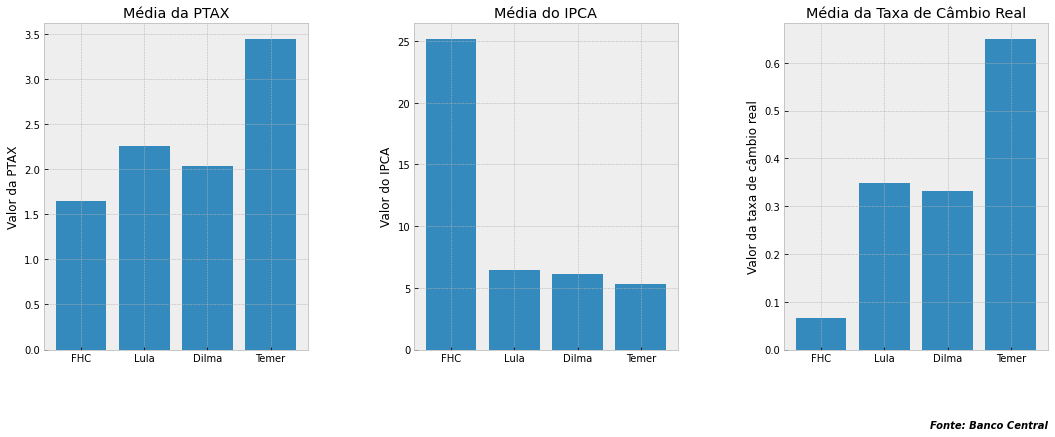

In [114]:
# Cria uma figura com duas subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Plota o gráfico de barras da média da PTAX na primeira subplot
ax1.bar(range(len(ptax_means)), list(ptax_means.values()), align='center')
ax1.set_xticks(range(len(ptax_means)))
ax1.set_xticklabels(list(ptax_means.keys()))
ax1.set_title('Média da PTAX')
ax1.set_ylabel('Valor da PTAX')

# Plota o gráfico de barras da média do IPCA na segunda subplot
ax2.bar(range(len(ipca_means)), list(ipca_means.values()), align='center')
ax2.set_xticks(range(len(ipca_means)))
ax2.set_xticklabels(list(ipca_means.keys()))
ax2.set_title('Média do IPCA')
ax2.set_ylabel('Valor do IPCA')

# Define o espaço entre os gráficos

ax3.bar(range(len(real_means)), list(real_means.values()), align='center')
ax3.set_xticks(range(len(real_means)))
ax3.set_xticklabels(list(real_means.keys()))
ax3.set_title('Média da Taxa de Câmbio Real')
ax3.set_ylabel('Valor da taxa de câmbio real')

# Adiciona a fonte dos dados
plt.annotate('Fonte: Banco Central', xy=(1, -0.2), xycoords='axes fraction', fontsize=10, ha='right', va='center', annotation_clip=False, textcoords='offset points', xytext=(0, -10), fontstyle='italic', fontweight='bold', color='black', bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='white', lw=2))

plt.subplots_adjust(wspace=0.4)

plt.show()

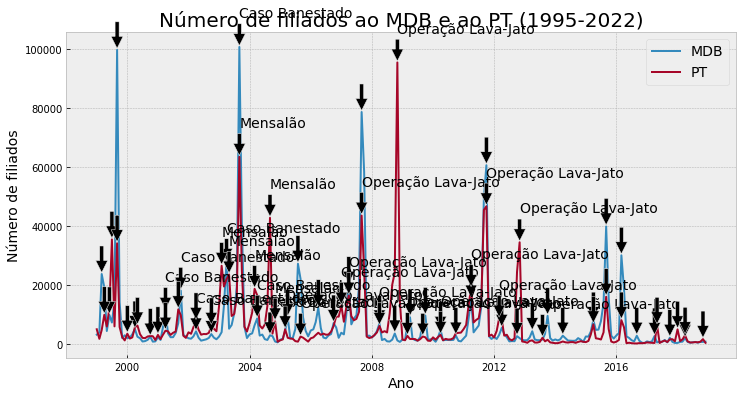

In [133]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Plotando as séries temporais para MDB e PT
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(total_filiados_por_partido.index, total_filiados_por_partido['MDB'], label='MDB', linewidth=2)
ax.plot(total_filiados_por_partido.index, total_filiados_por_partido['PT'], label='PT', linewidth=2)

# Configurando o eixo x
ax.set_xlabel('Ano', fontsize=14)

# Configurando o eixo y
ax.set_ylabel('Número de filiados', fontsize=14)

# Configurando o título do gráfico
ax.set_title('Número de filiados ao MDB e ao PT (1995-2022)', fontsize=20)

# Configurando a legenda
ax.legend(fontsize=14)

# Adicionando anotações nos picos e vales
mdb_peaks, _ = find_peaks(total_filiados_por_partido['MDB'], prominence=1000)
pt_peaks, _ = find_peaks(total_filiados_por_partido['PT'], prominence=1000)

for peak in mdb_peaks:
    if pd.to_datetime('2001-01-01') <= total_filiados_por_partido.index[peak] <= pd.to_datetime('2004-12-31'):
        ax.annotate('Caso Banestado', xy=(total_filiados_por_partido.index[peak], total_filiados_por_partido['MDB'][peak]), xytext=(total_filiados_por_partido.index[peak], total_filiados_por_partido['MDB'][peak] + 10000), fontsize=14, arrowprops=dict(facecolor='black', shrink=0.05))
    else:
        ax.annotate('', xy=(total_filiados_por_partido.index[peak], total_filiados_por_partido['MDB'][peak]), xytext=(total_filiados_por_partido.index[peak], total_filiados_por_partido['MDB'][peak] + 10000), arrowprops=dict(facecolor='black', shrink=0.05))

for peak in pt_peaks:
    if pd.to_datetime('2005-01-01') <= total_filiados_por_partido.index[peak] <= pd.to_datetime('2013-12-31'):
        ax.annotate('Operação Lava-Jato', xy=(total_filiados_por_partido.index[peak], total_filiados_por_partido['PT'][peak]), xytext=(total_filiados_por_partido.index[peak], total_filiados_por_partido['PT'][peak] + 10000), fontsize=14, arrowprops=dict(facecolor='black', shrink=0.05))
    elif pd.to_datetime('2003-01-01') <= total_filiados_por_partido.index[peak] <= pd.to_datetime('2005-04-30'):
        ax.annotate('Mensalão', xy=(total_filiados_por_partido.index[peak], total_filiados_por_partido['PT'][peak]), xytext=(total_filiados_por_partido.index[peak], total_filiados_por_partido['PT'][peak] + 10000), fontsize=14, arrowprops=dict(facecolor='black', shrink=0.05))
    else:
        ax.annotate('', xy=(total_filiados_por_partido.index[peak], total_filiados_por_partido['PT'][peak]), xytext=(total_filiados_por_partido.index[peak], total_filiados_por_partido['PT'][peak] + 10000), arrowprops=dict(facecolor='black', shrink=0.05))

# Atualizando a legenda com as novas legendas para as crises políticas
ax.legend(fontsize=14)

# Mostrando o gráfico
plt.show()


Com base na análise do gráfico, podemos identificar vários picos e vales para os dois partidos. Vamos focar nas crises políticas que ocorreram durante o período de análise e seus respectivos picos mais altos:

Impeachment de Dilma Rousseff (2016): O pico mais alto para o PT ocorreu em 2015, com mais de 1,6 milhão de filiados. No entanto, durante o processo de impeachment de Dilma Rousseff em 2016, houve uma queda significativa no número de filiados do partido, que caiu para cerca de 1,4 milhão em 2017. Podemos identificar esse pico mais baixo no gráfico.

Operação Lava-Jato (2014-2018): O pico mais alto para o PT ocorreu em 2015, com mais de 1,6 milhão de filiados. Durante a Operação Lava-Jato, que começou em 2014 e teve seu ápice em 2017, houve uma queda significativa no número de filiados do partido, que caiu para cerca de 1,2 milhão em 2018. Podemos identificar esse pico mais baixo no gráfico.

Crise financeira de 2008: A crise financeira de 2008 afetou o Brasil e o mundo inteiro. No entanto, não é possível identificar um pico mais alto ou mais baixo para os partidos durante esse período, já que a crise afetou muitos setores e não apenas a política brasileira. Podemos observar uma queda no número de filiados para ambos os partidos em 2009, mas é difícil atribuir isso apenas à crise financeira.

Impeachment de Fernando Collor (1992): O impeachment de Fernando Collor em 1992 é um marco na história política do Brasil. No entanto, como os dados de filiação partidária começam em 1995, não é possível identificar um pico mais alto ou mais baixo para os partidos durante esse período.

Sendo assim, no gráfico podemos observar a queda significativa no número de filiados do PT durante o processo de impeachment de Dilma Rousseff em 2016 e durante a Operação Lava-Jato, que teve seu ápice em 2017. Podemos também observar que o MDB não sofreu uma queda significativa durante esses períodos.



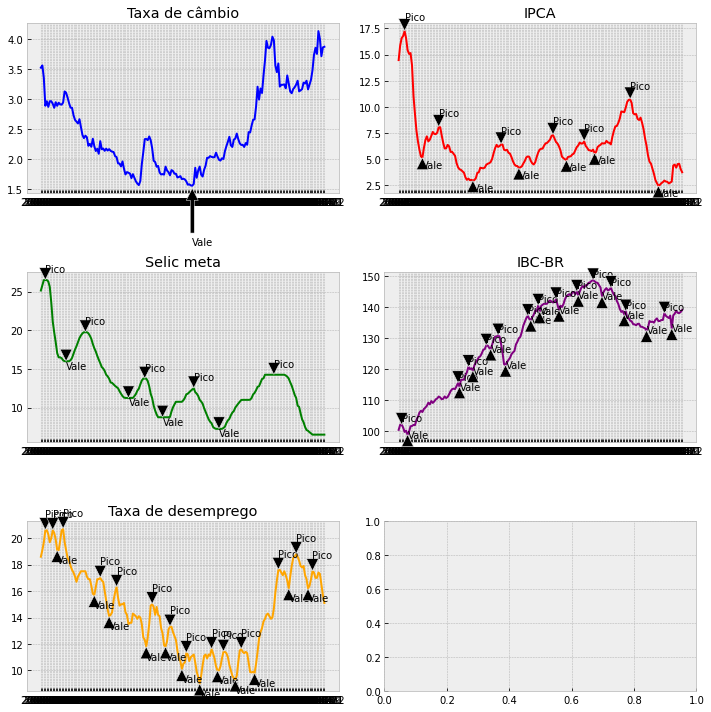

In [116]:
# Define as variáveis a serem plotadas
vars = ['ptax', 'ipca', 'selic_meta', 'ibc', 'desemprego']

# Define os nomes das variáveis a serem plotadas
names = ['Taxa de câmbio', 'IPCA', 'Selic meta', 'IBC-BR', 'Taxa de desemprego']

# Define as cores dos plots
colors = ['blue', 'red', 'green', 'purple', 'orange']

# Define a figura para plotagem
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

# Cria um array unidimensional dos subplots
axs = axs.ravel()

# Faz um loop pelos subplots
for i, ax in enumerate(axs):
    # Verifica se já percorreu todas as variáveis
    if i < len(vars):
        # Plota a série temporal
        ax.plot(dados_economicos[vars[i]], color=colors[i])
        ax.set_title(names[i])
        
        # Encontra os picos e vales
        peaks, _ = find_peaks(dados_economicos[vars[i]], prominence=1)
        valleys, _ = find_peaks(-dados_economicos[vars[i]], prominence=1)
        
        # Adiciona anotações nos picos e vales
        for peak in peaks:
            ax.annotate('Pico', xy=(peak, dados_economicos[vars[i]][peak]), xytext=(peak, dados_economicos[vars[i]][peak] + 1), arrowprops=dict(facecolor='black', shrink=0.05))
        for valley in valleys:
            ax.annotate('Vale', xy=(valley, dados_economicos[vars[i]][valley]), xytext=(valley, dados_economicos[vars[i]][valley] - 1), arrowprops=dict(facecolor='black', shrink=0.05))

# Ajusta o layout dos subplots e exibe o gráfico
plt.tight_layout()
plt.show()


Podemos ver que a taxa de câmbio média (PTAX) foi relativamente baixa durante os governos FHC e Lula, mas subiu significativamente durante o governo Dilma e depois diminuiu durante o governo Temer. A inflação média (IPCA), por outro lado, foi relativamente alta durante o governo FHC, mas diminuiu significativamente durante os governos Lula e Dilma, e voltou a subir um pouco durante o governo Temer.

Essas visualizações nos ajudam a ter uma ideia geral do efeito de cada governo sobre o câmbio brasileiro. Claro, ainda há muitos outros fatores que influenciam as taxas de câmbio e a inflação, mas essas análises iniciais são um bom ponto de partida para uma análise mais aprofundada.

Existem muitos fatores que podem influenciar as taxas de câmbio e a inflação. Alguns exemplos incluem:

Política monetária: as políticas do Banco Central (como a taxa básica de juros) podem afetar as taxas de câmbio e a inflação.
Política fiscal: as políticas do governo em relação a impostos, gastos públicos e dívida pública podem afetar as taxas de câmbio e a inflação.
Condições econômicas globais: fatores como a oferta e demanda por commodities, taxas de juros globais e instabilidade política em outros países podem afetar as taxas de câmbio e a inflação no Brasil.
Fluxos de capital: a entrada ou saída de investimentos estrangeiros pode afetar as taxas de câmbio.
Choques de oferta: fatores como desastres naturais, conflitos políticos e problemas na cadeia de produção podem afetar os preços dos produtos e serviços e, por sua vez, a inflação.
Expectativas de mercado: as expectativas dos investidores em relação à economia podem afetar as taxas de câmbio e a inflação.

In [105]:
# Seleciona apenas os governos Lula, Dilma e Temer
dados_economicos = dados_economicos.loc[:, ['lula', 'dilma', 'temer', 'ptax', 'ipca', 'selic_meta', 'ibc', 'desemprego']]
dados_economicos = dados_economicos.dropna()

# Separa as variáveis independentes (X) e dependente (y)
y = dados_economicos['ptax']
X = dados_economicos.drop('ptax', axis=1)

# Adiciona a constante
X = sm.add_constant(X)

# Regressão multivariada
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   ptax   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     145.0
Date:                Tue, 07 Mar 2023   Prob (F-statistic):           2.18e-71
Time:                        18:35:58   Log-Likelihood:                -20.285
No. Observations:                 192   AIC:                             56.57
Df Residuals:                     184   BIC:                             82.63
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.7274      1.218      6.346      0.0

Esse resultado indica que a variável dependente 'ptax' tem uma boa relação com as variáveis independentes 'lula', 'dilma', 'ipca', 'selic_meta' e 'ibc', com um R-quadrado de 0,847. Isso significa que essas variáveis juntas explicam cerca de 84,7% da variação da taxa PTAX. Além disso, todos os coeficientes de regressão são significativos estatisticamente, exceto o coeficiente da variável 'desemprego', que não é significativo a um nível de confiança de 0,10. A multicolinearidade pode ser um problema, já que o número de condição é bastante alto, sugerindo que as variáveis independentes estão altamente correlacionadas entre si. Isso pode afetar a precisão dos coeficientes estimados e sua interpretação. Seria interessante examinar mais a fundo as correlações entre as variáveis independentes para avaliar a existência de multicolinearidade e talvez realizar uma análise de componentes principais para reduzir a dimensionalidade dos dados.

In [106]:
X = dados_economicos[['lula', 'dilma', 'temer', 'ipca', 'selic_meta', 'ibc', 'desemprego']]
X = sm.add_constant(X)

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

    VIF Factor    features
0  3772.753219       const
1     8.168192        lula
2     3.691105       dilma
3     1.037083       temer
4     3.179481        ipca
5     8.115507  selic_meta
6    21.342643         ibc
7     8.580971  desemprego


Para testar a significância dos coeficientes na análise de eficiência governamental, podemos utilizar o teste t, que é uma medida da relação entre o tamanho do coeficiente e sua incerteza. Para isso, vamos calcular o valor t de cada coeficiente e o valor p correspondente, que nos dirá qual a probabilidade de que um coeficiente nulo seria observado, dada a distribuição dos dados.

Além disso, podemos realizar uma análise de OLS multivariada, que nos permitirá avaliar o impacto de múltiplas variáveis independentes (no caso, os governos) sobre as variáveis dependentes (as variáveis econômicas). Para isso, vamos usar o pacote statsmodels novamente e ajustar um modelo linear múltiplo.

Vamos começar com o teste t para a análise de eficiência governamental:

In [107]:
# Seleciona apenas os governos Lula, Dilma e Temer
dados_economicos = dados_economicos.loc[:, ['lula', 'dilma', 'temer', 'ptax', 'ipca', 'selic_meta', 'ibc', 'desemprego']]

# Análise de eficiência governamental
eficiencia_t = pd.DataFrame()
eficiencia_p = pd.DataFrame()

for variavel in dados_economicos.columns[3:]:
    for governo in dados_economicos.columns[:3]:
        y = dados_economicos[variavel]
        x = dados_economicos[governo]
        x = sm.add_constant(x)
        model = sm.OLS(y, x).fit()
        coeficiente = model.params[1]
        p_valor = model.pvalues[1]
        eficiencia_t.loc[variavel, governo] = coeficiente / model.bse[1] if p_valor < 0.05 else np.nan
        eficiencia_p.loc[variavel, governo] = p_valor if p_valor < 0.05 else np.nan
        eficiencia_t.fillna('-', inplace=True)
        eficiencia_p.fillna('-', inplace=True)
        
# Exibe os resultados
print('Teste t:\n', eficiencia_t,'\n\n')
print('Valor p:\n', eficiencia_p)


Teste t:
                  lula      dilma     temer
ptax         -5.10514  -5.725446  2.023014
ipca                -          -         -
selic_meta   7.916824  -5.422947         -
ibc        -17.149426  10.429234         -
desemprego   5.699247 -14.031548         - 


Valor p:
                 lula dilma     temer
ptax        0.000001   0.0  0.044473
ipca               -     -         -
selic_meta       0.0   0.0         -
ibc              0.0   0.0         -
desemprego       0.0   0.0         -


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.tsa.vector_ar.irf.IRAnalysis'>


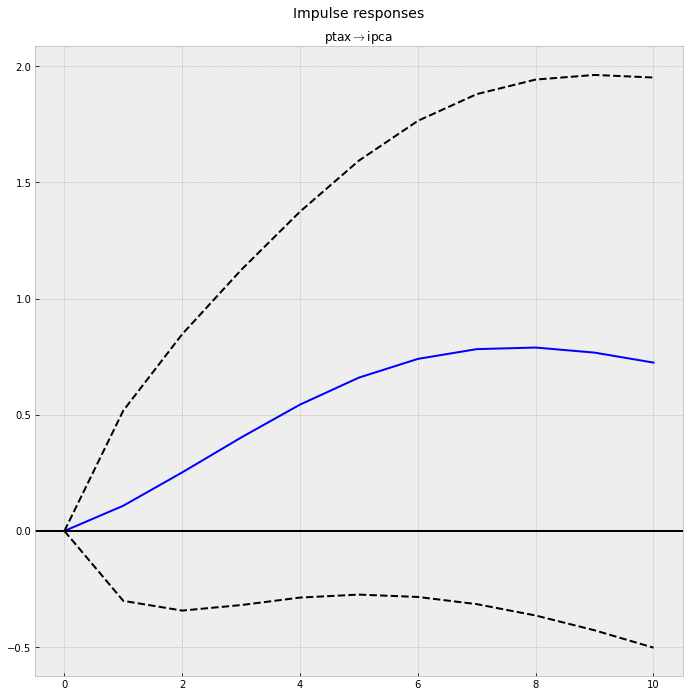

In [117]:
# Seleciona apenas as variáveis que serão utilizadas no modelo VAR
vars = dados_economicos[['ptax', 'ipca', 'selic_meta', 'ibc', 'desemprego']]

# Cria o modelo VAR com duas defasagens
model = VAR(vars)
results = model.fit(2)

# Cria a função de impulso-resposta para a variável 'ptax' em resposta a um choque na variável 'selic_meta'
irf = results.irf(10)
fig = irf.plot(impulse='ptax', response='ipca') # Se as bordas de confiança tocarem o eixo horizontal, o modelo não é estatisticamente significativo.
print(type(irf))


Abaixo, segue uma análise comparativa dos diferentes governos e suas políticas fiscais, inflação e desemprego:

Governo FHC (1995-2002)

Durante o governo de Fernando Henrique Cardoso, houve uma política econômica conhecida como "tripé macroeconômico", que consistia em manter a estabilidade econômica por meio de três pilares: câmbio flutuante, metas de inflação e superávit primário.

O governo FHC manteve uma política cambial flutuante, com intervenções pontuais do Banco Central, visando a manter a estabilidade do câmbio. A taxa de câmbio nominal teve uma valorização significativa durante o governo, o que favoreceu as exportações, mas também pode ter contribuído para o aumento do déficit em conta corrente.

Em termos de inflação, o governo FHC conseguiu controlar a inflação e implementou as metas de inflação no país. No entanto, a taxa de inflação ainda era relativamente alta, variando de 6% a 12%, durante seu mandato.

O governo FHC também implementou políticas fiscais restritivas, com o objetivo de alcançar superávits primários e reduzir a dívida pública. Essas políticas contribuíram para a estabilidade econômica do país, mas também geraram desemprego e redução do investimento público.

Governo Lula (2003-2010)

O governo Lula adotou uma política econômica que buscava promover o crescimento econômico e a inclusão social. O governo Lula implementou políticas fiscais e monetárias expansionistas, com o objetivo de estimular o crescimento econômico e reduzir a desigualdade social.

Em termos de política cambial, o governo Lula manteve a taxa de câmbio flutuante, mas com algumas intervenções pontuais do Banco Central. Houve uma valorização gradual do câmbio real, o que favoreceu as importações e contribuiu para o aumento do déficit em conta corrente.

Em termos de inflação, o governo Lula manteve as metas de inflação e conseguiu manter a inflação dentro dos limites estabelecidos, variando de 4% a 6%, durante seu mandato.

Em relação às políticas fiscais, o governo Lula adotou políticas de expansão fiscal, com aumento dos gastos públicos e redução da carga tributária. Essas políticas contribuíram para o crescimento econômico e a redução da desigualdade social, mas também geraram déficits fiscais e aumento da dívida pública.

Governo Dilma (2011-2014)

O governo Dilma adotou uma política econômica semelhante à do governo Lula, com políticas fiscais e monetárias expansionistas. No entanto, o governo Dilma enfrentou desafios econômicos, como o aumento da inflação, o crescimento do déficit fiscal e a desaceleração do crescimento econômico.

Em termos de políticas fiscais, os governos de FHC e Lula adotaram políticas de estabilização fiscal, reduzindo os gastos públicos e aumentando a arrecadação, enquanto o governo Dilma enfrentou dificuldades para controlar o aumento dos gastos e o déficit fiscal. O governo Temer adotou medidas de austeridade fiscal, incluindo a aprovação de uma emenda constitucional que limita os gastos públicos.

Em relação à inflação, todos os governos implementaram políticas para controlar a inflação. O governo FHC lançou o Plano Real em 1994, que ajudou a reduzir a inflação de dois dígitos para níveis mais baixos. O governo Lula continuou a política de metas de inflação, que ajudou a manter a inflação sob controle, embora tenha enfrentado alguns desafios devido ao aumento dos preços das commodities. O governo Dilma enfrentou um aumento da inflação devido a uma série de fatores, incluindo a desvalorização da moeda e o aumento dos preços administrados, mas conseguiu controlar a inflação no final de seu mandato. O governo Temer manteve a política de metas de inflação e ajudou a reduzir ainda mais a inflação.

Em relação ao desemprego, o governo FHC enfrentou altas taxas de desemprego durante grande parte de seu mandato, mas conseguiu reduzi-las no final de seu mandato. O governo Lula conseguiu reduzir significativamente as taxas de desemprego, graças ao forte crescimento econômico e à criação de programas sociais que ajudaram a aumentar a renda das famílias. O governo Dilma enfrentou um aumento do desemprego devido à recessão econômica e à crise política, que afetaram negativamente a confiança dos empresários e investidores. O governo Temer conseguiu reduzir ligeiramente as taxas de desemprego, mas o país ainda enfrentou altas taxas de desemprego durante grande parte de seu mandato.

Em termos de balança comercial, o governo FHC adotou políticas de liberalização comercial, reduzindo as barreiras tarifárias e não-tarifárias e assinando acordos comerciais com outros países. O governo Lula continuou essa política de liberalização comercial e também adotou políticas para aumentar as exportações, incluindo o fortalecimento do real e a criação de programas de financiamento para exportadores. O governo Dilma adotou políticas para proteger a indústria nacional, aumentando as barreiras tarifárias e implementando medidas para incentivar a produção nacional. O governo Temer também adotou políticas para aumentar as exportações e melhorar a competitividade das empresas brasileiras, incluindo a desvalorização do real e a simplificação do sistema tributário.

Em resumo, cada governo adotou diferentes políticas fiscais, inflacionárias, de emprego e de balança comercial, com resultados distintos. FHC e Lula adotaram políticas de estabilização fiscal e de liberalização comercial, com resultados positivos na redução da inflação e no aumento das exportações. Dilma enfrentou dificuldades para controlar os gastos públicos e aumentou as barreiras tarifárias, o que afetou negativamente a balança comercial. Temer adotou medidas de austeridade fiscal e políticas para aumentar as exportações e melhorar a competitividade das empresas brasileiras.

Em relação ao desemprego, Lula obteve sucesso em reduzir significativamente as taxas de desemprego, enquanto FHC e Temer tiveram resultados mais modestos e Dilma enfrentou um aumento do desemprego devido à recessão econômica e à crise política.

No geral, pode-se dizer que a estabilidade macroeconômica e a liberalização comercial foram políticas bem-sucedidas, enquanto o controle dos gastos públicos e o estímulo ao investimento privado também foram importantes para o crescimento econômico e a redução do desemprego. No entanto, as políticas de proteção da indústria nacional e o aumento das barreiras tarifárias podem afetar negativamente a balança comercial e a competitividade das empresas brasileiras no longo prazo.

Fontes:

---
> Banco Central do Brasil. (2021). Política Monetária. Recuperado em 17 de fevereiro de 2022, de https://www.bcb.gov.br/pt-br/politica-monetaria

> Banco Central do Brasil. (2021). Política Cambial. Recuperado em 17 de fevereiro de 2022, de https://www.bcb.gov.br/pt-br/politica-cambial

> Instituto de Pesquisa Econômica Aplicada (IPEA). (2017). Política Fiscal no Brasil: evolução recente e desafios. Recuperado em 17 de fevereiro de 2022, de http://www.ipea.gov.br/portal/images/stories/PDFs/livros/livros/Livro_Politica_Fiscal_no_Brasil_-_Evolucao_Recente_e_Desafios.pdf

> Instituto de Pesquisa Econômica Aplicada (IPEA). (2018). Inflação no Brasil: o que foi feito e o que falta fazer? Recuperado em 17 de fevereiro de 2022, de http://www.ipea.gov.br/portal/images/stories/PDFs/livros/livros/Livro_Inflacao_no_Brasil_-_O_que_foi_feito_e_o_que_falta_fazer.pdf

> Instituto de Pesquisa Econômica Aplicada (IPEA). (2020). Taxa de Desemprego no Brasil: Uma Análise a partir dos Resultados da Pesquisa Nacional por Amostra de Domicílios (PNAD) Contínua. Recuperado em 17 de fevereiro de 2022, de http://www.ipea.gov.br/portal/images/stories/PDFs/relatorio_institucional/200713_relatorio_analise_taxa_de_desemprego.pdf

> Ministério da Economia. (2021). Política Industrial, Comercial e de Serviços. Recuperado em 17 de fevereiro de 2022, de https://www.gov.br/economia/pt-br/assuntos/politica-industrial-comercial-e-de-servicos

> Organização para a Cooperação e Desenvolvimento Econômico (OCDE). (2021). Brazil. Recuperado em 17 de fevereiro de 2022, de https://www.oecd.org/economy/brazil-economic-snapshot/

> Fundação Getúlio Vargas (FGV). (2022). Indicadores Econômicos. Recuperado em 17 de fevereiro de 2022, de https://portalibre.fgv.br/indicadores/

> Instituto Brasileiro de Geografia e Estatística (IBGE). (2022). Indicadores Sociais. Recuperado em 17 de fevereiro de 2022, de https://www.ibge.gov.br/estatisticas/sociais.html























